In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qutip import tensor, num, qeye, create, destroy, basis, sesolve, expect, mesolve
from compute_g0 import compute_g0
from compute_fidelity import compute_fidelity

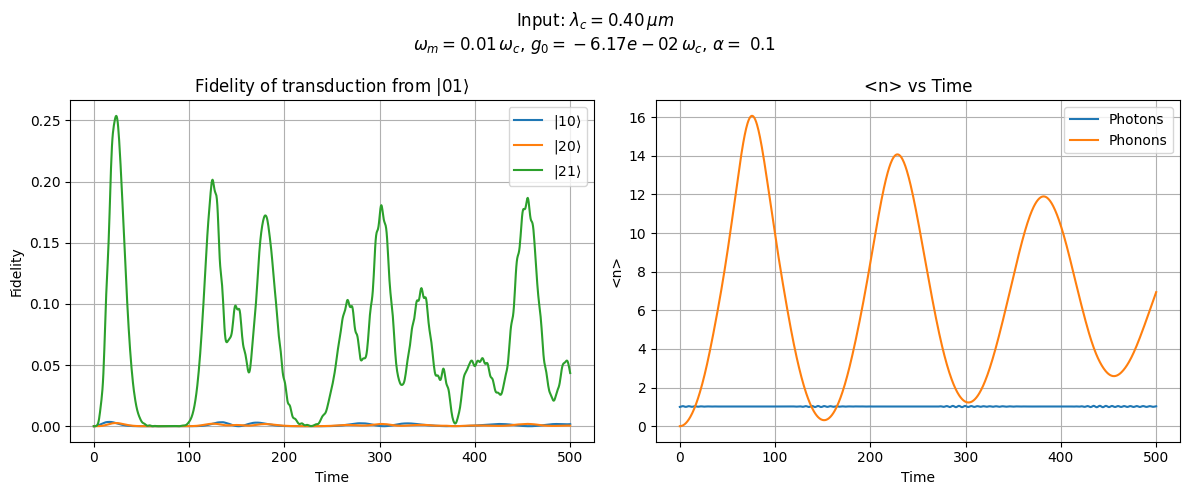

In [35]:
# specify all wavelengths in micrometers
omega_array, g_0_array = compute_g0(outcar_name='OUTCAR_hydrostatic_100kB', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= 2*1e-5, semiconductor_length= 1e-5)
alpha = 0.1
omega_photon = 2*np.pi*3*10**8/(0.4*10**-6)
omega_phonon = 2*np.pi*10**13

max_fidelities, results = compute_fidelity(omega_array, g_0_array, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time= 500,
                 plot = True, set_g_0 = None)

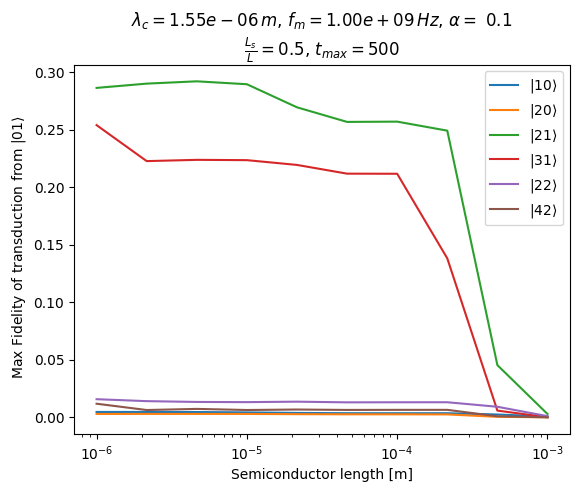

In [52]:
alpha = 0.1
wavelength_photon = 1.55*1e-6 # m
frequency_phonon = 1e9 # Hz
tmax = 500

omega_phonon = 2*np.pi*frequency_phonon
cavity_semiconductor_length_factor = 2

omega_photon = 2*np.pi*3*10**8/wavelength_photon
expected_keys = ['10', '20', '21', '31', '22', '42']
fidelity_dict = {key: [] for key in expected_keys}

lengths = np.logspace(-6, -3, 10)
for semiconductor_length in lengths:
    omega_array, g_0_array = compute_g0(outcar_name='OUTCAR_hydrostatic_100kB', 
        plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot=False,
        cavity_length= cavity_semiconductor_length_factor*semiconductor_length, semiconductor_length= semiconductor_length)
    
    max_fidelities, results = compute_fidelity(omega_array, g_0_array, alpha, omega_photon, omega_phonon,
                 photon_loss_rate= 0, truncation_photon_space = 5, truncation_phonon_space = 50, simulation_time = tmax,
                 plot = False, set_g_0 = None)

    for key, value in max_fidelities.items():
        fidelity_dict[key].append(value)

for key in expected_keys:
    plt.plot(lengths, fidelity_dict[key], label=rf'$\vert {key}\rangle$')
plt.xscale('log')
plt.xlabel('Semiconductor length [m]')
plt.ylabel(r' Max Fidelity of transduction from $\vert 01 \rangle$')
plt.title(rf'$\lambda_c = {wavelength_photon:.2e} \, m$, ' rf'$f_m = {frequency_phonon:.2e} \, Hz$, $\alpha =$ {alpha}' '\n' r'$\frac{L_s}{L} = $' f'{1/cavity_semiconductor_length_factor}, ' r'$t_{max} = $' f'{tmax}')
plt.legend()
plt.show()

In [13]:
def compute_fixed_dimensions(photon_wavelength_range, omega_phonon_range, semiconductor_length, alpha, cav_sem_factor = 1.1):
    simulation_time = 100
    
    photon_loss_rate = 0
    truncation_photon_space = 10
    truncation_phonon_space = 20

    ###
    cavity_length = semiconductor_length * cav_sem_factor
    omega_photon_range = 2*np.pi*3*10**8/np.array(photon_wavelength_range)
    omega_array, g_0_array = compute_g0(outcar_name='OUTCAR_hydrostatic_100kB', 
            plot_min_wavelength=0.4*1e-6, plot_max_wavelength= 1.7*1e-6, plot = False,
            cavity_length=cavity_length, semiconductor_length= semiconductor_length)

    # Initialize dictionaries to track the best fidelities and corresponding parameters for each state
    best_fidelities = {
        "target_state10": 0,
        "target_state20": 0,
        "target_state21": 0,
        "target_state22": 0,
        "target_state31": 0,
        "target_state42": 0
    }
    corresponding_fidelity_times = {
        "target_state10": 0,
        "target_state20": 0,
        "target_state21": 0,
        "target_state22": 0,
        "target_state31": 0,
        "target_state42": 0
    }
    best_params = {
        "target_state10": None,
        "target_state20": None,
        "target_state21": None,
        "target_state22": None,
        "target_state31": None,
        "target_state42": None
    }

    # Initialize variables to track the best fidelity across all states
    best_overall_fidelity = 0
    best_overall_state = None
    best_overall_time = 0
    best_overall_params = None

    # Loop over the parameter ranges for omega_photon and omega_phonon
    for omega_photon in omega_photon_range:
        for omega_phonon in omega_phonon_range:
            result = compute_fidelity(omega_array, g_0_array, alpha,
                                    omega_photon, omega_phonon, photon_loss_rate,
                                    truncation_photon_space, truncation_phonon_space, simulation_time=simulation_time, plot=False)

            # Iterate over the states and update the best fidelities and peak times
            for state in best_fidelities:
                # Access the fidelity and peak time for the state
                max_fidelity_key = f"max_fidelity_{state}"
                peak_time_key = f"peak_time_{state}"
                
                # Check if the keys exist in the result dictionary
                if max_fidelity_key in result and peak_time_key in result:
                    max_fidelity = float(result[max_fidelity_key])
                    peak_time = float(result[peak_time_key])

                    # Update if the current fidelity is better than the stored best for that state
                    if max_fidelity > best_fidelities[state]:
                        best_fidelities[state] = max_fidelity
                        corresponding_fidelity_times[state] = peak_time
                        best_params[state] = (omega_photon, omega_phonon, f"State {state.split('_')[1]}", peak_time)

                    # Also track the best fidelity across all states
                    if max_fidelity > best_overall_fidelity:
                        best_overall_fidelity = max_fidelity
                        best_overall_state = state
                        best_overall_time = peak_time
                        best_overall_params = (omega_photon, omega_phonon, f"State {state.split('_')[1]}", peak_time)

    print(f'alpha = {alpha}')
    print(f'Cavity length: {cavity_length:.2e}, semiconductor length: {semiconductor_length}')

    results_data = []
    for state in best_fidelities:
        results_data.append({
            "State": best_params[state][2],
            "Max Fidelity": np.format_float_scientific(best_fidelities[state], precision=2),
            "Peak Time": np.round(corresponding_fidelity_times[state], 2),
            "Photon Wavelength (m)": np.format_float_scientific(3*10**8*2*np.pi/(best_params[state][0]), precision=2),
            "Omega Phonon (Hz)": np.format_float_scientific(best_params[state][1]/(2*np.pi), precision=2),
        })
    df = pd.DataFrame(results_data)
    df['Max Fidelity'] = pd.to_numeric(df['Max Fidelity'])
    df = df.sort_values('Max Fidelity', ascending=False).set_index('Max Fidelity')
    display(df)

In [16]:
#     # Define the ranges for omega_photon and omega_phonon
# photon_wavelength_range = [0.4*1e-6, 1.55*1e-6]
# omega_phonon_range = 2*np.logspace(8, 14, 20) # 100 MHz - 100 THz
# compute_fixed_dimensions(photon_wavelength_range, omega_phonon_range, semiconductor_length=1e-5, alpha=0.1, cav_sem_factor = 2)

In [17]:
photon_wavelength_range = [0.4*1e-6]
omega_phonon_range = 2*np.pi*np.logspace(8, 14, 20) # 100 MHz - 100 THz
lengths = np.logspace(-6, -4, 5)
factors = [2] #np.linspace(1.05, 2, 3)
alpha = 0.1
for semiconductor_length in lengths:
    for cav_sem_factor in factors:
        compute_fixed_dimensions(photon_wavelength_range, omega_phonon_range, semiconductor_length, cav_sem_factor)

alpha = 2
Cavity length: 1.10e-06, semiconductor length: 1e-06


,State,Peak Time,Photon Wavelength (m),Omega Phonon (Hz)
Max Fidelity,,,,
0.1150,State state21,97.90,4.e-07,1.e+14
0.1070,State state31,78.28,4.e-07,1.e+08
0.0870,State state10,9.61,4.e-07,1.e+14
0.0773,State state20,31.63,4.e-07,1.13e+13
0.0637,State state22,40.94,4.e-07,5.46e+12
0.0494,State state42,37.44,4.e-07,1.e+08


alpha = 2
Cavity length: 3.48e-06, semiconductor length: 3.162277660168379e-06


,State,Peak Time,Photon Wavelength (m),Omega Phonon (Hz)
Max Fidelity,,,,
0.1180,State state10,61.26,4.e-07,2.34e+13
0.1020,State state31,69.87,4.e-07,2.34e+13
0.0887,State state21,97.60,4.e-07,2.64e+12
0.0604,State state22,36.04,4.e-07,1.e+08
0.0550,State state42,7.91,4.e-07,4.83e+13
0.0510,State state20,91.49,4.e-07,2.64e+12


alpha = 2
Cavity length: 1.10e-05, semiconductor length: 1e-05


,State,Peak Time,Photon Wavelength (m),Omega Phonon (Hz)
Max Fidelity,,,,
0.1050,State state21,17.12,4.e-07,1.e+08
0.1030,State state10,100.00,4.e-07,2.34e+13
0.0853,State state31,82.48,4.e-07,1.13e+13
0.0581,State state20,82.18,4.e-07,5.46e+12
0.0555,State state22,13.01,4.e-07,1.13e+13
0.0465,State state42,25.83,4.e-07,5.46e+12


alpha = 2
Cavity length: 3.48e-05, semiconductor length: 3.1622776601683795e-05


,State,Peak Time,Photon Wavelength (m),Omega Phonon (Hz)
Max Fidelity,,,,
0.1310,State state21,52.35,4.e-07,1.e+08
0.0846,State state10,86.99,4.e-07,1.e+14
0.0815,State state31,54.45,4.e-07,1.13e+13
0.0639,State state20,52.65,4.e-07,2.64e+12
0.0609,State state22,39.04,4.e-07,1.13e+13
0.0525,State state42,80.38,4.e-07,1.13e+13


alpha = 2
Cavity length: 1.10e-04, semiconductor length: 0.0001


,State,Peak Time,Photon Wavelength (m),Omega Phonon (Hz)
Max Fidelity,,,,
0.0825,State state21,71.07,4.e-07,4.83e+13
0.0773,State state10,62.86,4.e-07,4.83e+13
0.0579,State state31,44.24,4.e-07,4.83e+13
0.0429,State state20,47.05,4.e-07,4.83e+13
0.0390,State state22,75.98,4.e-07,4.83e+13
0.0262,State state42,36.54,4.e-07,4.83e+13
